<a href="https://colab.research.google.com/github/jhchang/Sentiment-Analysis-on-Arabic-Text/blob/main/Sentinment_Analysis_on_Arabic_Lanugage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have been learning Arabic through Duolingo, the Alif Ba, and Al-Kitaab series. While I am familiar with Machine Learning and it's applications to NLP, I am only familiar with the challegenes in the English Language space. This notebook is created to demonstrate the unique challeneges for NLP in the Arabic languages and how to address them.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

# Downloading and previewing Dataset

The dataset is made up of 1800 tweets in Arabic and can be found here: https://github.com/komari6/Arabic-twitter-corpus-AJGT

In [2]:
# Raw file URL (not the HTML preview)
url = "https://raw.githubusercontent.com/komari6/Arabic-twitter-corpus-AJGT/master/AJGT.xlsx"

# Read the Excel file using pandas
df = pd.read_excel(url, engine='openpyxl')


# Data Exploration

### Basic Dataframe Inspection

In [3]:
print(df.head())
print(df.sample(5))

   ID                                               Feed Sentiment
0   1   اربد فيها جامعات اكثر من عمان ... وفيها قد عم...  Positive
1   2   الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...  Negative
2   3                            كله رائع بجد ربنا يكرمك  Positive
3   4                                 لسانك قذر يا قمامه  Negative
4   5  ​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...  Negative
        ID                                               Feed Sentiment
1021  1022           عليا النعمه ابدا لا هو ولا الخروف التاني  Negative
1        2   الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...  Negative
1009  1010                                        عجل يا الله  Positive
318    319  اللهم اجعلنا ممن تنظر اليهم بحب اشتياق اجعلنا ...  Positive
1691  1692                    يا خساره عليكو يا شباب المستقبل  Negative


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1800 non-null   int64 
 1   Feed       1800 non-null   object
 2   Sentiment  1800 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.3+ KB
None


In [5]:
print(df.isnull().sum())

ID           0
Feed         0
Sentiment    0
dtype: int64


In [6]:
print(df.shape)

(1800, 3)


In [7]:
print(df['Sentiment'].value_counts())

Sentiment
Positive    900
Negative    900
Name: count, dtype: int64


We have a perfectly even distrubution of class labels. No need for data augmentation techniques for the imbalance of classes

### Text Length Analysis

        char_count   word_count
count  1800.000000  1800.000000
mean     46.805000     9.002222
std      46.054977     8.240547
min       6.000000     1.000000
25%      23.000000     4.000000
50%      36.000000     7.000000
75%      58.000000    11.000000
max     864.000000   143.000000


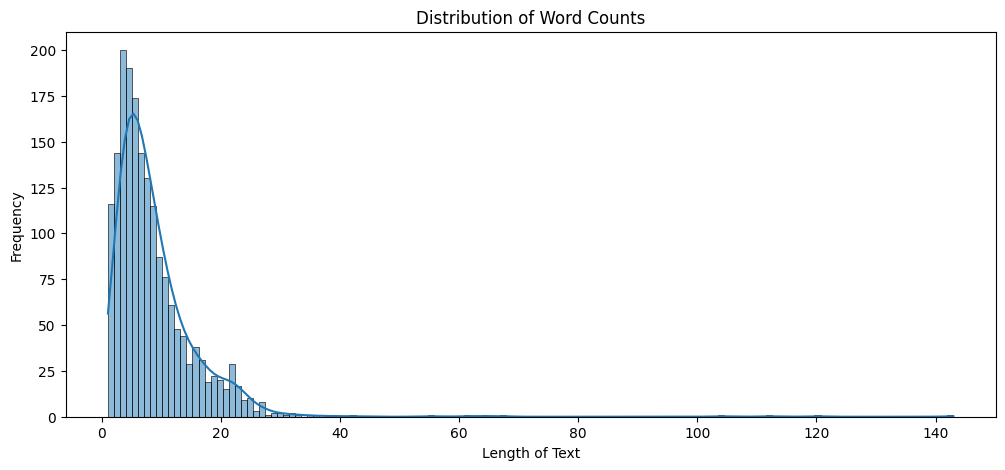

In [8]:
# Add columns for text length
df['char_count'] = df['Feed'].apply(len)
df['word_count'] = df['Feed'].apply(lambda x: len(x.split()))

# Summary stats
print(df[['char_count', 'word_count']].describe())

# Plot distributions
plt.figure(figsize=(12, 5))
sns.histplot(df['word_count'], bins=140, kde=True)
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

In [9]:
len(df[df['word_count'] > 100])

4

In [10]:
len(df[df['char_count'] > 300])

7

In [11]:
length_90 = df['char_count'].quantile(0.90)
length_95 = df['char_count'].quantile(0.95)

print(f"90th percentile character length: {int(length_90)}")
print(f"95th percentile character length: {int(length_95)}")

length_90 = df['word_count'].quantile(0.90)
length_95 = df['word_count'].quantile(0.95)

print(f"90th percentile word length: {int(length_90)}")
print(f"95th percentile word length: {int(length_95)}")

90th percentile character length: 92
95th percentile character length: 113
90th percentile word length: 17
95th percentile word length: 22


### Upon review of the histogram, we can conclude:

1. **Most tweets are short:** There is a character limit on tweets that encourage people to keep their tweets short


2. **Few tweets are long (outliers):** There is a right skew in the data that indicates a small amount of tweets are long


---
### Data pruning options:

1. Delete short tweets that do not contribute much context.

2. Truncate or split long tweets to ensure they fit within the model's tokenization limits

3. Establishing a max length: It specifies the maximum number of words that the model will process for each review.

### Pros and Cons to Setting Max Token or Word Length:

Setting a **maximum length** (max\_len) for text inputs is a standard preprocessing step in NLP, especially when working with models like RNNs, LSTMs, Transformers, or BERT.

Here’s a clear breakdown of the **pros and cons**:

---

## ✅ Pros of Setting a Maximum Text Length

### 1. **Computational Efficiency**

* Fixed-length input allows for **efficient batching** and **GPU acceleration**.
* Reduces **training time** and **memory usage**.

### 2. **Model Compatibility**

* Required by models like BERT, GPT, or RNNs which expect **fixed-length inputs** (or paddable sequences).
* Prevents runtime errors from variable-length inputs.

### 3. **Control Over Noise**

* Long texts often contain **irrelevant or redundant information**.
* Truncating can help focus on the most **important part** of the text (e.g., beginning of a review or headline).

### 4. **Avoid Overfitting**

* Especially in small datasets, long sequences can lead to **memorization**, not generalization.
* Shorter, normalized lengths reduce this risk.

---

## ❌ Cons of Setting a Maximum Text Length

### 1. **Loss of Information**

* Truncating longer texts **removes content**, possibly losing important context or conclusions.
* Especially problematic for domains like **legal**, **medical**, or **scientific text** where key info may appear later.

### 2. **Bias Toward Start of Text**

* Most truncation keeps the **start (head)** and drops the end (tail).
* If useful info is at the end, the model may **learn skewed patterns**.

### 3. **Underutilization of Data**

* If max\_len is set **too small**, you waste valuable training data.
* If set **too large**, you waste memory on padding shorter texts.

---

## Best Practices

| Scenario                      | Suggested Strategy                                               |
| ----------------------------- | ---------------------------------------------------------------- |
| Classification tasks          | Truncate if needed, often start of text is enough                |       |          |
| Fine-tuning transformers      | Use tokenizer’s `max_length`, `truncation=True`                  |

---

## How to Choose `max_len`

  ```python
  df['text'].str.len().describe()
  ```
* Pick a length that covers \~90–95% of samples while balancing memory and compute.

---



# Preprocessing

Although text preprocessing is a well-established research domain for English, Arabic NLP remains comparatively underdeveloped and has distinct linguistic complexities and unique computational challenges.

I will cover some NLP preprocessing tasks in the scope of the Arabic Language.

---

### **1. Text Normalization**  
#### **A. Script Standardization**  
- **Unicode Normalization**: Convert Arabic characters to a consistent form (e.g., `ك` vs. `ک`).  
  ```python
  import unicodedata
  text = unicodedata.normalize('NFKD', text)  # Decompose then recompose
  ```
- **Hamza Normalization**: Resolve variations of أ/إ/آ to أ (e.g., `إسلام` → `أسلام`).  
- **Tatweel Removal**: Strip elongation characters (ـ) (e.g., `عــــــربي` → `عربي`).  

#### **B. Diacritic Handling**  
- **Strip Harakat**: Remove vowel marks (ـَـْـُـ) unless needed for tasks like Quranic analysis.  
  ```python
  text = re.sub(r'[\u064B-\u065F]', '', text)  # Removes all diacritics
  ```
- **Optional**: Preserve diacritics for poetry or ASR by using a whitelist.  

#### **C. Number Normalization**  
- Convert numerals to Arabic words (e.g., `٣` → `ثلاثة`) or replace with `[NUM]`.  
- Address Hindu-Arabic (١٢٣) vs. Western digits (123).  

---

### **2. Noise Removal**  
- **Remove Non-Arabic Scripts**: Keep only Arabic Unicode ranges (0600–06FF, 0750–077F, FB50–FDFF, FE70–FEFF).  
  ```python
  text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\uFB50-\uFDFF\uFE70-\uFEFF]', ' ', text)
  ```
- **Clean Social Media Noise**:  
  - Remove hashtags, mentions, and URLs (or replace with `[URL]`).  
  - Normalize repeated characters (e.g., `هههه` → `ههه`).  

---

### **3. Tokenization**  
#### **A. Word-Level**  
- **Challenges**: Clitic pronouns (ـكم, ـها) and conjunctions (ـو).  
- **Tools**:  
  - **Farasa Segmenter**: Splits attached pronouns (e.g., `كتابها` → `كتاب + ها`).  
  - **CAMeL Tools**: Handles dialectal Arabic.  

#### **B. Subword-Level**  
- **Byte-Pair Encoding (BPE)**: Use pretrained Arabic tokenizers (e.g., `AraBERT`, `MARBERT`).  

---

### **4. Stopword Removal**  
- **Curated Lists**: Use Arabic stopword lists from `NLTK` or build custom ones for dialects.  
  ```python
  from nltk.corpus import stopwords
  stops = set(stopwords.words('arabic'))  # MSA-only
  ```
- **Caution**: Dialectal stopwords (e.g., Egyptian "بس" meaning "only") may differ.  

---

### **5. Stemming/Lemmatization**  
#### **A. Light Stemming**  
- Remove prefixes/suffixes while preserving the root:  
  - **Farasa Stemmer**: `كتاباتنا` → `كتابة`.  
  - **ISRI Stemmer**: Rule-based but aggressive.  

#### **B. Root Extraction (Lemmatization)**  
- **Farasa Lemmatizer**: Maps words to tri-literal roots (e.g., `يستلمون` → `سلم`).  
- **Khoja Algorithm**: Classical Arabic root extraction.  

---

### **6. Dialect Handling**  
- **Normalization to MSA**: Use tools like `CALIMA-star` for Levantine/Egyptian-to-MSA conversion.  
- **Dialect Identification**: Classify text (e.g., Gulf vs. Maghrebi) before processing.  

---

### **7. Advanced Steps**  
#### **A. Named Entity Recognition (NER)**  
- Mask entities (e.g., `[LOC:القاهرة]`) to avoid splitting during tokenization.  

#### **B. Spelling Correction**  
- **Farasa Correct**: Fixes common errors (e.g., `اللغة العربيه` → `اللغة العربية`).  

#### **C. Coreference Resolution**  
- Replace pronouns with nouns (e.g., `هو` → `الرجل`) for coherence.  

---

### **Python Example (Full Pipeline)**  
```python
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer
import pyarabic.araby as araby  # For diacritic removal

def preprocess_arabic(text):
    # Normalize
    text = araby.strip_tashkeel(text)  # Remove diacritics
    text = araby.normalize_hamza(text)
    
    # Tokenize with Farasa
    segmenter = FarasaSegmenter()
    text = segmenter.segment(text)  # Splits attached pronouns
    
    # Stemming
    stemmer = FarasaStemmer()
    text = stemmer.stem(text)
    
    return text
```

---

# Lemmatization/Stemming Models and Libraries

There are different preprocessing steps that each language does differently, however lemmatization is one step that requires extensive altering and computational resources to perform.

Below is a list of pros and cons of some popular lemmitization libraries.
---

### **1. Farasa Lemmatizer**  
**Developed by:** Qatar Computing Research Institute (QCRI)  
**Type:** Rule-based + Statistical  
**Availability:** API, Python (`farasapy`), and standalone tool.  

#### **Pros:**  
✅ **Highly accurate** (one of the best for Arabic NLP tasks).  
✅ **Fast processing** (optimized for large-scale text).  
✅ **Handles complex morphology** (roots, prefixes, suffixes well).  
✅ **Supports modern standard Arabic (MSA) and some dialects.**  

#### **Cons:**  
❌ **Not entirely free** (API has rate limits; full access may require a license).  
❌ **No direct deep learning integration** (relies on traditional methods).  

---

### **2. CAMeL Tools Lemmatizer**  
**Developed by:** CAMeL Lab (NYU Abu Dhabi)  
**Type:** Rule-based + Machine Learning  
**Availability:** Python library (`camel_tools`).  

#### **Pros:**  
✅ **Open-source and free** (no API restrictions).  
✅ **Good for MSA and some dialectal variations.**  
✅ **Works well with other Arabic NLP tools (tokenization, POS tagging).**  

#### **Cons:**  
❌ **Slightly slower than Farasa for large datasets.**  
❌ **Less accurate on highly dialectal or noisy text.**  

---

### **3. Stanza (Stanford NLP) Arabic Lemmatizer**  
**Type:** Neural (Transformer-based)  
**Availability:** Python (`stanza`).  

#### **Pros:**  
✅ **Deep learning-based** (better for context-aware lemmatization).  
✅ **Part of a full NLP pipeline** (tokenization, POS, dependency parsing).  
✅ **Decent accuracy on MSA.**  

#### **Cons:**  
❌ **Slower than rule-based systems (GPU helps).**  
❌ **Struggles with dialects and informal Arabic.**  

---

### **4. ISRI Arabic Stemmer (NLTK-Compatible)**  
**Type:** Rule-based (Light Stemming)  
**Availability:** Python (`nltk.stem.isri`).  

#### **Pros:**  
✅ **Simple and fast** (good for basic stemming, not full lemmatization).  
✅ **Works with NLTK.**  

#### **Cons:**  
❌ **Only does stemming (not true lemmatization).**  
❌ **Low accuracy for nuanced text.**  

---

### **5. MADAMIRA (Java-Based)**  
**Developed by:** Columbia University  
**Type:** Rule-based  
**Availability:** Java/Python (via wrappers).  

#### **Pros:**  
✅ **Very precise for MSA.**  
✅ **Handles morphology rigorously.**  

#### **Cons:**  
❌ **Outdated (no active development).**  
❌ **Complex setup (Java dependency).**  

---

### **6. AraBERT Lemmatization (Transformers)**  
**Type:** BERT-based (Contextual)  
**Availability:** HuggingFace (`AraBERT`).  

#### **Pros:**  
✅ **State-of-the-art for context-aware lemmatization.**  
✅ **Works well with noisy text (social media, dialects).**  

#### **Cons:**  
❌ **Heavy resource usage (needs GPU for speed).**  
❌ **Overkill if you only need lemmatization.**  

---

### **Comparison Summary**
| Tool          | Accuracy | Speed  | Dialects | Ease of Use | Best For |
|--------------|----------|--------|----------|-------------|----------|
| **Farasa**   | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | Limited  | Medium      | Production systems |
| **CAMeL**    | ⭐⭐⭐⭐   | ⭐⭐⭐  | Limited  | Easy        | Research, MSA |
| **Stanza**   | ⭐⭐⭐⭐   | ⭐⭐    | No       | Easy        | Full NLP pipeline |
| **ISRI**     | ⭐⭐      | ⭐⭐⭐⭐⭐ | No       | Very Easy   | Quick stemming |
| **MADAMIRA** | ⭐⭐⭐⭐   | ⭐⭐    | No       | Hard        | Legacy systems |
| **AraBERT**  | ⭐⭐⭐⭐⭐ | ⭐     | Yes      | Medium      | Advanced NLP |

---

I want to focus on lemmatization since I have noticed some preprocessing for the arabic language skip this step and I want to see how models perform with and without lemmitization. Below will be very simple models to demonstrate the power of lemmitization. For lemmitization libraries we will try out CAMeL and Stanza due to their free usage and perforamce vs overhead costs for our needs.

### Word Frequency Analysis

In [12]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 44.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [13]:
import stanza
print(stanza.__version__)

1.10.1


In [14]:
from collections import Counter

# Initialize pipeline
stanza.download('ar')
# nlp = stanza.Pipeline('ar')
nlp = stanza.Pipeline('ar', processors='tokenize,pos,lemma,ner', use_gpu=True) # If connected to GPU




INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ar (Arabic) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ar/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| ner       | aqmar_charlm  |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [15]:
# Analyze all texts
for text in df['Feed'].head():
    # docs = [nlp(text) for text in df['text'].head(100)]  # Limit batch size
    doc = nlp(text)
    print(f"Original: {text}")
    print("Tokens:", [word.text for sent in doc.sentences for word in sent.words])
    print("Lemmas:", [word.lemma for sent in doc.sentences for word in sent.words])
    print("---")

Original:  اربد فيها جامعات اكثر من عمان ... وفيها قد عمان ونص لعيبه المنتخب منها ... و 80 % من مطربين الاردن منها
Tokens: ['اربد', 'في', 'ها', 'جامعات', 'اكثر', 'من', 'عمان', '.', '.', '.', 'و', 'في', 'ها', 'قد', 'عمان', 'ونص', 'ل', 'عيب', 'ه', 'المنتخب', 'من', 'ها', '.', '.', '.', 'و', '80', '%', 'من', 'مطربين', 'الاردن', 'من', 'ها']
Lemmas: ['اربد', 'فِي', 'هُوَ', 'جَامِعَة', 'أَكثَر', 'مِن', 'عَمَّان', '.', '.', '.', 'وَ', 'فِي', 'هُوَ', 'قَد', 'عَمَّان', 'ونص', 'لِ', 'عَيب', 'هُوَ', 'مُنتَخَب', 'مِن', 'هُوَ', '.', '.', '.', 'وَ', '80', '%', 'مِن', 'مُطَرَّب', 'أُردُنّ', 'مِن', 'هُوَ']
---
Original:  الحلو انكم بتحكوا على اساس انو الاردن ما فيه فساد سرقات
Tokens: ['الحلو', 'انكم', 'ب', 'تحكوا', 'على', 'اساس', 'انو', 'الاردن', 'ما', 'في', 'ه', 'فساد', 'سرقات']
Lemmas: ['الحلو', 'هُوَ', 'بِ', 'تَحَكَّى', 'عَلَى', 'أَسَاس', 'انو', 'أُردُنّ', 'مَا', 'فِي', 'هُوَ', 'فَسَاد', 'سَرِيق']
---
Original:  كله رائع بجد ربنا يكرمك
Tokens: ['كل', 'ه', 'رائع', 'بجد', 'ربنا', 'يكرمك']
Lemmas: ['كُ

In [16]:
text = df.at[df.index[0], 'Feed']
doc = nlp(text)
print(text)

for sentence in doc.sentences:
    # print("🔹 Sentence:", sentence)
    for word in sentence.words:
        print(f"  Text: {word.text}, Lemma: {word.lemma}, POS: {word.upos}, Morph: {word.feats}")


 اربد فيها جامعات اكثر من عمان ... وفيها قد عمان ونص لعيبه المنتخب منها ... و 80 % من مطربين الاردن منها
  Text: اربد, Lemma: اربد, POS: X, Morph: None
  Text: في, Lemma: فِي, POS: ADP, Morph: AdpType=Prep
  Text: ها, Lemma: هُوَ, POS: PRON, Morph: Case=Gen|Gender=Fem|Number=Sing|Person=3|PronType=Prs
  Text: جامعات, Lemma: جَامِعَة, POS: NOUN, Morph: Case=Nom|Definite=Cons|Number=Plur
  Text: اكثر, Lemma: أَكثَر, POS: ADJ, Morph: Case=Nom|Definite=Ind|Gender=Masc|Number=Sing
  Text: من, Lemma: مِن, POS: ADP, Morph: AdpType=Prep
  Text: عمان, Lemma: عَمَّان, POS: NOUN, Morph: Case=Gen|Definite=Ind|Number=Sing
  Text: ., Lemma: ., POS: PUNCT, Morph: None
  Text: ., Lemma: ., POS: PUNCT, Morph: None
  Text: ., Lemma: ., POS: PUNCT, Morph: None
  Text: و, Lemma: وَ, POS: CCONJ, Morph: None
  Text: في, Lemma: فِي, POS: ADP, Morph: AdpType=Prep
  Text: ها, Lemma: هُوَ, POS: PRON, Morph: Case=Gen|Gender=Fem|Number=Sing|Person=3|PronType=Prs
  Text: قد, Lemma: قَد, POS: AUX, Morph: None
  Tex

In [17]:
print("Named Entities:")
for text in df['Feed'].head():
    doc = nlp(text)
    for ent in doc.ents:
        print(f"  Entity: {ent.text}, Type: {ent.type}")

Named Entities:
  Entity: عمان, Type: LOC
  Entity: عمان, Type: LOC
  Entity: الاردن, Type: LOC


In [18]:
from collections import Counter

pos_counter = Counter()

for text in df['Feed'].head():
    doc = nlp(text)
    for sent in doc.sentences:
        for word in sent.words:
            pos_counter[word.upos] += 1

print("\n📈 POS Tag Frequency:", pos_counter.most_common())



📈 POS Tag Frequency: [('NOUN', 20), ('PRON', 13), ('ADP', 12), ('X', 8), ('CCONJ', 8), ('VERB', 8), ('ADJ', 6), ('PUNCT', 6), ('PART', 2), ('AUX', 1), ('NUM', 1), ('SYM', 1), ('DET', 1), ('SCONJ', 1)]


In [19]:
entity_counter = Counter()

for text in df['Feed'].head():
    doc = nlp(text)
    for ent in doc.ents:
        entity_counter[ent.type] += 1

print("\n📌 Entity Type Frequency:", entity_counter)


📌 Entity Type Frequency: Counter({'LOC': 3})


In [20]:
# create doc for whole text once here then you can add if statements to check if doc exists in all the loops
# actually I think they look over the text line by line so I'd need to combine all the logic. It's nice for cells
# to be somewhat independent but I could combine logic if computation takes too long.

In [21]:
# Add word/token counts
def count_words(text):
    doc = nlp(text)
    return sum(len(sent.words) for sent in doc.sentences)

df['word_count'] = df['Feed'].apply(count_words)
df['char_count'] = df['Feed'].apply(len)

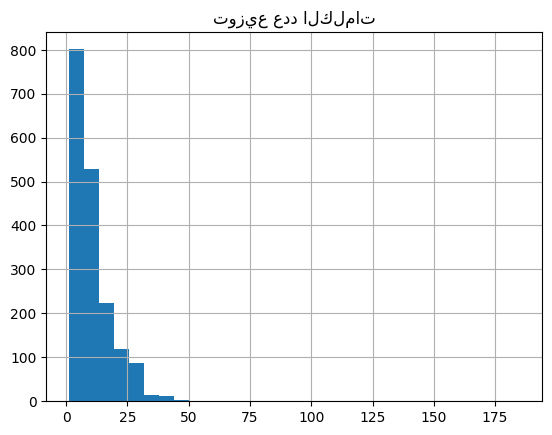

In [22]:
# Plot
import matplotlib.pyplot as plt
df['word_count'].hist(bins=30)
plt.title('توزيع عدد الكلمات')
plt.show()

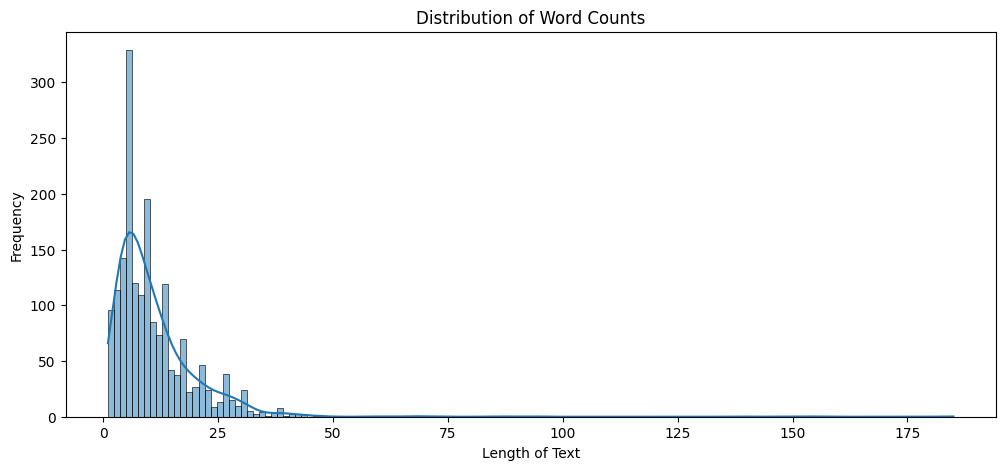

In [23]:
# Plot
plt.figure(figsize=(12, 5))
sns.histplot(df['word_count'], bins=140, kde=True)
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

In [24]:
word_counter = Counter()

for text in df['Feed']:
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            word_counter[word.text] += 1  # Use word.lemma for root forms


<ipython-input-25-e3a7ffc2209e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x='count', y='word', palette='mako')


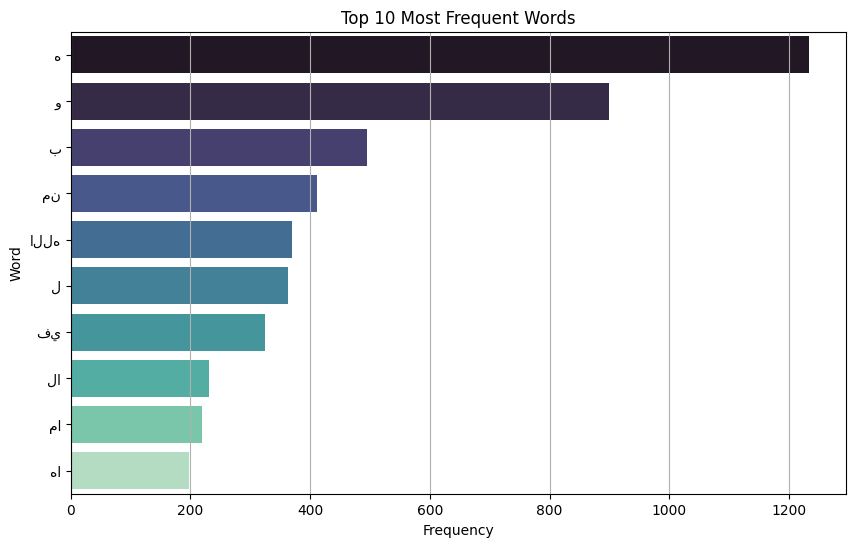

In [25]:
# Convert to DataFrame
word_freq_df = pd.DataFrame(word_counter.items(), columns=['word', 'count'])

# Sort by frequency
top_words = word_freq_df.sort_values(by='count', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_words, x='count', y='word', palette='mako')
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.grid(axis='x')
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


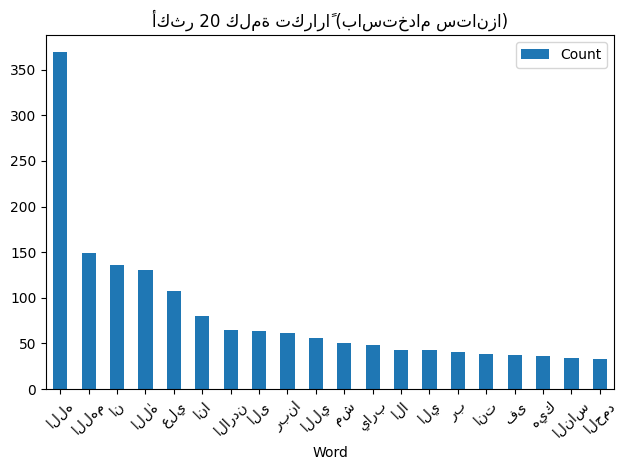

In [26]:
# Arabic stopwords (example list - replace with your own)
# arabic_stopwords = set(["في", "من", "إلى", "على", "أن", "هو", "هي", "ال", "و", "لا"])
from nltk.corpus import stopwords
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

def get_words(text):
    """Extract and filter words using Stanza"""
    doc = nlp(text)
    words = []
    for sentence in doc.sentences:
        for word in sentence.words:
            # Filter out stopwords and punctuation
            if (word.text.lower() not in arabic_stopwords and
                word.pos not in ["PUNCT", "NUM"]):  # Exclude numbers/punctuation
                words.append(word.text)
    return words

# Process all texts
all_words = []
for text in df['Feed']:
    all_words.extend(get_words(text))

# Get top 20 frequent words
word_freq = Counter(all_words).most_common(20)

# Plot
pd.DataFrame(word_freq, columns=['Word', 'Count']).plot.bar(x='Word', y='Count')
plt.title('أكثر 20 كلمة تكراراً (باستخدام ستانزا)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sentinment Analysis using various Models

Logistic Regression is commonly used to initially evaluate datasets. Implementation and runtime is quick and easy and can serve as a baseline model for classification tasks. Many other models can outperfom logistic regression with the proper training so models try to aim to beat the performance of logistic regressions in the early stages of development. Gridsearch is used to train the model with various hyperparameters and pick the most performant one.

This model below is also run without any preprocessing. Any preprocessing we do below should aim to outperfrom the results of this model.

In [27]:
feature = df['Feed']
target = df['Sentiment']
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

# make pipeline
pipe = make_pipeline(TfidfVectorizer(),
                    LogisticRegression())
# make param grid
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(pipe, param_grid, cv=5)
model.fit(X_train,Y_train)

# make prediction and print accuracy
prediction = model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.83
              precision    recall  f1-score   support

    Negative       0.86      0.78      0.82       176
    Positive       0.81      0.88      0.84       184

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.83      0.83      0.83       360



In order to demonstrate the power of all the preprocessing techniques shown above I'll demonstrate the results of just removing punctuation, Arabic diacritics, elongation, and stopwords (which is available in NLTK corpus).

In [28]:
# first we define a list of arabic and english punctiations that we want to get rid of in our text

punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

# Arabic stop words with nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def preprocess(text):

    '''
    text is an arabic string input

    the preprocessed text is returned
    '''

    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)

    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)

    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    text = ' '.join(word for word in text.split() if word not in arabic_stopwords)

    return text

df_simple = df.copy()
df_simple['Feed'] = df_simple['Feed'].apply(preprocess)
print(df_simple.head(5))

   ID                                               Feed Sentiment  \
0   1  اربد جامعات اكثر عمان وفيها عمان ونص لعيبه الم...  Positive   
1   2   الحلو انكم بتحكوا علي اساس انو الاردن فساد سرقات  Negative   
2   3                            كله راءع بجد ربنا يكرمك  Positive   
3   4                                    لسانك قذر قمامه  Negative   
4   5  ​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...  Negative   

   char_count  word_count  
0         104          33  
1          56          13  
2          24           6  
3          19           5  
4         124          31  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
df_simple.head()

,ID,Feed,Sentiment,char_count,word_count
0,1,اربد جامعات اكثر عمان وفيها عمان ونص لعيبه الم...,Positive,104,33
1,2,الحلو انكم بتحكوا علي اساس انو الاردن فساد سرقات,Negative,56,13
2,3,كله راءع بجد ربنا يكرمك,Positive,24,6
3,4,لسانك قذر قمامه,Negative,19,5
4,5,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...,Negative,124,31


In [30]:
feature = df_simple['Feed']
target = df_simple['Sentiment']
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

# make pipeline
pipe = make_pipeline(TfidfVectorizer(),
                    LogisticRegression())
# make param grid
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(pipe, param_grid, cv=5)
model.fit(X_train,Y_train)

# make prediction and print accuracy
prediction = model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.82
              precision    recall  f1-score   support

    Negative       0.85      0.78      0.81       176
    Positive       0.81      0.86      0.83       184

    accuracy                           0.82       360
   macro avg       0.83      0.82      0.82       360
weighted avg       0.83      0.82      0.82       360



This simple preprocessing step barely changes the results and this implies that the dataset is already very clean. Let us try more transformative text preprocessing.

In [31]:
nlp = stanza.Pipeline(lang='ar', processors='tokenize,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| lemma     | padt_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


This time we will use the lemmas given to use by the lemmatizer from stanza and see if the logistic regression model gives us better results.

In [32]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = []
    for sentence in doc.sentences:
        for word in sentence.words:
            lemmas.append(word.lemma)
    return ' '.join(lemmas)

df['Lemmatized'] = df['Feed'].apply(lemmatize)

In [33]:
feature = df['Lemmatized']
target = df['Sentiment']
# splitting into train and tests
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size =.2, random_state=100)

# make pipeline
pipe = make_pipeline(TfidfVectorizer(),
                    LogisticRegression())
# make param grid
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# create and fit the model
model = GridSearchCV(pipe, param_grid, cv=5)
model.fit(X_train,Y_train)

# make prediction and print accuracy
prediction = model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.76
              precision    recall  f1-score   support

    Negative       0.76      0.75      0.75       176
    Positive       0.76      0.77      0.77       184

    accuracy                           0.76       360
   macro avg       0.76      0.76      0.76       360
weighted avg       0.76      0.76      0.76       360



In [34]:
df.at[df.index[0], 'Lemmatized']

'أَربَد فِي هُوَ جَامِعَة أَكثَر مِن عَمَّان . . . وَ فِي هُوَ قَد عَمَّان وِنصَ لِ عَيب هُوَ مُنتَخَب مِن هُوَ . . . وَ 80 % مِن مُطَرِّب أُردُنّ مِن هُوَ'

We notice that the lemmatized text actually performs worse than the non-lemmatized text. Let's investigate why.

```
Basic custom text Logistic Regression

Accuracy score is 0.82
              precision    recall  f1-score   support

    Negative       0.85      0.78      0.81       176
    Positive       0.81      0.86      0.83       184

    accuracy                           0.82       360
   macro avg       0.83      0.82      0.82       360
weighted avg       0.83      0.82      0.82       360

=====================================================

Lemmatized Logistic Regression

Accuracy score is 0.76
    Negative       0.76      0.75      0.75       176
    Positive       0.76      0.77      0.77       184

    accuracy                           0.76       360
   macro avg       0.76      0.76      0.76       360
weighted avg       0.76      0.76      0.76       360
```

Before we address the myriad of reasons why this unexpected behavior could be occuring, I want to explain why NLP data pipelines lemmatization.

# Why We Use Lemmatization in NLP (And When It Helps or Hurts)

Lemmatization is a fundamental text normalization technique in natural language processing, but its effectiveness depends on the specific application. Here's a comprehensive look at its purpose and trade-offs:

## Core Purpose of Lemmatization

1. **Word Form Consolidation**:
   - Reduces inflectional forms to a common base (lemma)
   - Example: "running", "ran", "runs" → "run"

2. **Vocabulary Reduction**:
   - Decreases feature space dimensionality by grouping variants
   - Helps with data sparsity issues in statistical models

3. **Semantic Normalization**:
   - Connects different grammatical forms to the same concept
   - Preserves meaning better than stemming (which just chops endings)

## Where Lemmatization Helps Most

### Beneficial Use Cases:
1. **Information Retrieval**:
   - Improves recall by matching query variants ("swim" finds "swimming")
   - Search engines often use lemmatization internally

2. **Topic Modeling**:
   - Produces cleaner topics by grouping word forms
   - LDA models benefit from reduced feature space

3. **Machine Translation**:
   - Helps align words across languages with different inflection patterns

4. **Knowledge Graphs**:
   - Creates cleaner entity representations by normalizing surface forms

5. **Morphologically Rich Languages**:
   - Especially valuable for languages like Arabic, German, or Russian with many inflections

## When Lemmatization Can Hurt Performance

1. **Context-Sensitive Tasks**:
   - Sentiment analysis: "This product *exceeds* expectations" vs "This product *exceeded* expectations" may carry different strengths

2. **Temporal Analysis**:
   - Verb tenses matter in time-series text (e.g., earnings reports: "will grow" vs "grew")

3. **Simple Models**:
   - Linear models may lack capacity to exploit the cleaner but more abstract features

4. **Short Text/Domain-Specific Jargon**:
   - Technical terms or named entities often shouldn't be lemmatized

5. **Feature-Starved Problems**:
   - When you have limited training data, preserving original forms provides more signal

## Technical Trade-offs

| Aspect | With Lemmatization | Without Lemmatization |
|--------|-------------------|-----------------------|
| Feature Space | Smaller, denser | Larger, sparser |
| Computational Cost | Higher preprocessing | Lower preprocessing |
| Model Complexity | Works better with sophisticated models | Tolerable with simple models |
| Context Preservation | Loses some surface form info | Maintains original distinctions |
| Multilingual Support | Needs language-specific lemmatizers | Universally applicable |


# In our specific case we can identify multiple topics that attribute to our problem in this list below:

## Simple Models
In our scenario, our model is extremely simple and cannot learn abstract domains as well as more complicated models like Nueral Networks. Therefore, cleaner data where relationships could be found more easily could not be discovered. Cleaner data for logisitc regression might just mean the elimination of features.

## Feature-Started Problems
I only fed in IF-IDF data into our models. This lack of features makes it hard for the model to learn from so little data, and lemmatization removes even more data. Therefore the logisitc regression models perform worse in our scenario. Tweets are also very short so lemmatization removes sparsity that short-text classification relies upon.



---


## ✅ Potential Solutions

### ✅ 1. **Use the original `preprocess()` + lemmatized text combined**

```python
df['clean'] = df['Feed'].apply(preprocess)
df['hybrid'] = df['clean'] + ' ' + df['Lemmatized']
```

Train on `df['hybrid']` — this gives the model:

* Morphology-rich raw words
* Generalized lemmas
* Combined signals

---

### ✅ 2. **Character-level TF-IDF**

Arabic morphology is rich. Try:

```python
TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5))
```

This will help capture root patterns like "سعيد", "سعيده", "سعداء" etc.

---

### ✅ 3. **POS Filtering in Stanza**

Only keep words with POS in `['ADJ', 'VERB', 'NOUN']` — usually most relevant to sentiment.

Update the `lemmatize()` function to:

```python
def lemmatize(text):
    doc = nlp(text)
    lemmas = []
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.upos in ['ADJ', 'VERB', 'NOUN']:
                lemmas.append(word.lemma)
    return ' '.join(lemmas)
```

---

### ✅ 4. **Try stemming instead of lemmatization**

Use NLTK’s `ISRIStemmer` or the `ArabicLightStemmer` from `camel_tools` — they might preserve more sentiment features than lemmas.

---


In [35]:
nlp = stanza.Pipeline(lang='ar', processors='tokenize,lemma,pos')

def lemmatize(text):
    doc = nlp(text)
    lemmas = []
    for sentence in doc.sentences:
        for word in sentence.words:
            if word.upos in ['ADJ', 'VERB', 'NOUN']:
                lemmas.append(word.lemma)
    return ' '.join(lemmas)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [36]:
df['clean'] = df['Feed'].apply(preprocess)
df['lemmas'] = df['Feed'].apply(lemmatize)
df['Hybrid'] = df['clean'] + ' ' + df['lemmas']


In [37]:
feature = df['Hybrid']
target = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    feature, target, test_size=0.2, random_state=100
)

# TF-IDF + Logistic Regression Pipeline
pipe = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(max_iter=1000)
)

param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

model = GridSearchCV(pipe, param_grid, cv=5)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print(f"Accuracy score is {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))


Accuracy score is 0.82
              precision    recall  f1-score   support

    Negative       0.85      0.77      0.81       176
    Positive       0.80      0.87      0.83       184

    accuracy                           0.82       360
   macro avg       0.82      0.82      0.82       360
weighted avg       0.82      0.82      0.82       360



## Our accuracy score is back to the original model. This is good enough for now. There are more complicated models that have been proved to perform better on a wide variety of tasks, so spending time fine-tuning models would be better spend on other models. Let's try out other models!

In [38]:
pipe = make_pipeline(TfidfVectorizer(),
                    RandomForestClassifier())

param_grid = {'randomforestclassifier__n_estimators':[10, 100, 1000],
             'randomforestclassifier__max_features':['sqrt', 'log2']}

rf_model = GridSearchCV(pipe, param_grid, cv=5)
rf_model.fit(X_train,Y_train)

prediction = rf_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.83
              precision    recall  f1-score   support

    Negative       0.85      0.80      0.82       176
    Positive       0.82      0.86      0.84       184

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.83      0.83      0.83       360



In [39]:
pipe = make_pipeline(TfidfVectorizer(),
                    MultinomialNB())
pipe.fit(X_train,Y_train)
prediction = pipe.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.86
              precision    recall  f1-score   support

    Negative       0.92      0.77      0.84       176
    Positive       0.81      0.93      0.87       184

    accuracy                           0.86       360
   macro avg       0.87      0.85      0.85       360
weighted avg       0.86      0.86      0.85       360



In [40]:
pipe = make_pipeline(TfidfVectorizer(),
                     SVC())
param_grid = {'svc__kernel': ['rbf', 'linear', 'poly'],
             'svc__gamma': [0.1, 1, 10, 100],
             'svc__C': [0.1, 1, 10, 100]}

svc_model = GridSearchCV(pipe, param_grid, cv=3)
svc_model.fit(X_train, Y_train)

prediction = svc_model.predict(X_test)
print(f"Accuracy score is {accuracy_score(Y_test, prediction):.2f}")
print(classification_report(Y_test, prediction))

Accuracy score is 0.85
              precision    recall  f1-score   support

    Negative       0.85      0.84      0.84       176
    Positive       0.85      0.85      0.85       184

    accuracy                           0.85       360
   macro avg       0.85      0.85      0.85       360
weighted avg       0.85      0.85      0.85       360



These ML models performed similarly and quickly. Naive Bayes was the winner by a small margin and it is also very fast to run. Depending on the purpose of your task, you might want to choose a model with higher precision or recall.

Our next task would be to try to augment the data even further with words embeddings, bag of words, or word2vec. With high deminsional features, more complicated models like Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM), Gated Recurrent Units (GRU), Transformer Models, Convolutional Neural Networks (CNNs). We will dicuss more advanced data augmentation/preprocessing techniques and more advanced models that are better equipped to leverage higher dimensional feature space in the next notebook. You can find it on my github:

https://github.com/jhchang/Sentiment-Analysis-on-Arabic-Text

Credit:
- https://towardsdatascience.com/arabic-sentiment-analysis-5e21b77fb5ea/
